In [191]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.io import imread
import numpy as np
#import talos
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

from sklearn.externals import joblib
from skimage.transform import pyramid_gaussian
from skimage import color
import pandas as pd
from sklearn.model_selection import cross_val_score,train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Conv2D,Input,Flatten,Dense,Dropout

from keras.models import Model,Sequential,load_model

from sklearn import decomposition
%matplotlib inline


# Path of project

In [192]:

path="C:/Users/HP/Desktop/"

# Extract features by hog function

In [204]:
def extract_features():
    orientations = 9
    pixels_per_cell = [6, 6] 
    cells_per_block = [2, 2]
    block_norm='L1'
    transform_sqrt=False
    feature_vector=True
    pos_feat_ph="pos_feat_ph"
    neg_feat_ph="neg_feat_ph"
    for im_path in glob.glob(os.path.join('data/images/pos_person', "*")):
        #print("im_path",im_path)
        im = imread(im_path)
        #print("im",im)
        chaine=len(im.shape)>2
        #print("im_shape",im.shape)
        fd = hog(im, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,block_norm=block_norm,
                     transform_sqrt=transform_sqrt,feature_vector=feature_vector ,multichannel=chaine)
        fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
        #print("fd_name",fd_name)
        fd_path = os.path.join(pos_feat_ph, fd_name)
        #print("fd_path",fd_path)
        joblib.dump(fd, fd_path)
    print("hog operation for pos_image is finished")
    for im_path in glob.glob(os.path.join('data/images/neg_person', "*")):
        im = imread(im_path)
        fd = hog(im, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,block_norm=block_norm,
                     transform_sqrt=transform_sqrt,feature_vector=feature_vector ,multichannel=chaine)
        fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(neg_feat_ph, fd_name)
        joblib.dump(fd, fd_path)
    print("hog operation for neg_image is finished")

In [205]:
extract_features()

hog operation for pos_image is finished
hog operation for neg_image is finished


# Loding and labeling the hog vetcors

In [206]:
def load_labeling():
    labels = []
    i=0
    fdd=0
    l=0
    b=0
    for feat_path in glob.glob(os.path.join("pos_feat_ph","*.feat")):
        #print("feat_path",feat_path)
        fd = joblib.load(feat_path)
        #print("fd",fd)
        if i==0:
            fdd=np.reshape(fd,(1,-1))
            #print("fdd",fdd)
            l=np.ones((1,1))
            #print("l value",l)
            b=l
        fdd=np.vstack((fdd,np.reshape(fd,(1,-1))))
        #print("fdd",fdd)
        l=np.vstack((l,b))
        #print("l value",l)
        i+=1
    print('pos image')  
    i=0
    b=np.zeros((1,1))
    for feat_path in glob.glob(os.path.join("neg_feat_ph","*.feat")):
        fd = joblib.load(feat_path)
        fdd=np.vstack((fdd,np.reshape(fd,(1,-1))))
        l=np.vstack((l,b))
    print('neg image')
    return fdd,l

In [207]:
vectors,labels=load_labeling()

pos image
neg image


In [208]:
print("x value",vectors.shape)
print("y value",labels.shape)

x value (6563, 6480)
y value (6563, 1)


# Making csv dataset

In [199]:
cols={'col'+str(i):vectors[:,i] for i in  range(0,vectors.shape[1])}
df=pd.DataFrame(cols)
label={'label':labels[:,0]}
lab=pd.DataFrame(label)
x=df[cols].values
y=lab[label].values
dataframe=pd.concat([df,lab],axis=1)
dataframe.to_csv('data.csv')

# Creation of  classification model 

In [238]:
def create_model(units=4,kernel_initializer='TruncatedNormal',activation='linear',activation1='linear',bias_initializer='Constant'):
    model = Sequential()
    model.add(Dense(units*256, input_dim=162, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(units*128, input_dim=162, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(units*64, input_dim=162, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(units*32, input_dim=162, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(units*16, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer, activation=activation1))
    model.add(Dropout(.1))
    model.add(Dense(units*8, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer, activation=activation1))
    model.add(Dropout(.3))
    model.add(Dense(units, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer, activation=activation1))
    model.add(Dense(4, kernel_initializer='normal', activation='linear'))
    model.add(Dense(1, kernel_initializer=kernel_initializer,bias_initializer=bias_initializer, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Read Data 

In [239]:
data=pd.read_csv('data3.csv',sep=',')
x=data[["col"+str(i) for i in range(0,6480)]].values
#x=data[["col"+str(i) for i in range(0,3780)]].values
y=data[["label"]].values


In [240]:
# from numpy import array
# from numpy import mean
# from numpy import cov
# from numpy.linalg import eig
# # define a matrix
# # calculate the mean of each column
# M = mean(x.T, axis=1)
# print(M)
# # center columns by subtracting column means
# C = x - M
# print(C)
# # calculate covariance matrix of centered matrix
# V = cov(C.T)
# print(V)
# # eigendecomposition of covariance matrix
# values, vectors = eig(V)
# print(vectors)
# print(values)
# # project data
# P = vectors.T.dot(C.T)
# print(P.T)

# wrapp keras model by scikit learn model & minimize number of features

In [241]:
cls=KerasClassifier(build_fn=create_model,epochs=120,batch_size=32,verbose=2,validation_split=0.11)
pca=decomposition.PCA(n_components=162)

# activation = ['softmax', 'relu', 'sigmoid', 'linear']
# activation1 = ['softmax', 'relu', 'sigmoid', 'linear']
# neurons = [2, 4, 6, 8, 10, 12]
# kernel_initializer = ['RandomNormal', 'TruncatedNormal', 'Zeros', 'Ones', 'Constant']
# bias_initializer=  ['RandomNormal', 'TruncatedNormal', 'Zeros', 'Ones', 'Constant']

# param_grid = dict(activation=activation, activation1=activation1, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, units=neurons)
# cls =RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=param_grid, 
#                           verbose=20,  n_iter=10, n_jobs=1)
print("x value",x.shape)
print("y value",y.shape)
pca.fit(x)
x=pca.transform(x)
print("x value",x.shape)
print("y value",y.shape)
x_t,x_te,y_t,y_te=train_test_split(x, y, test_size=0.11, random_state=42,stratify=y)

x value (6563, 6480)
y value (6563, 1)
x value (6563, 162)
y value (6563, 1)


# Trainning the model

In [242]:
cls.fit(x_t,y_t)
#hist=cls.fit(x_t,y_t)
#print("Best: %f using %s" % (hist.best_score_, hist.best_params_))

Train on 5198 samples, validate on 643 samples
Epoch 1/120
 - 15s - loss: 0.3166 - accuracy: 0.8684 - val_loss: 0.1841 - val_accuracy: 0.9285
Epoch 2/120
 - 9s - loss: 0.1970 - accuracy: 0.9254 - val_loss: 0.1800 - val_accuracy: 0.9331
Epoch 3/120
 - 9s - loss: 0.1935 - accuracy: 0.9263 - val_loss: 0.1846 - val_accuracy: 0.9207
Epoch 4/120
 - 9s - loss: 0.1897 - accuracy: 0.9313 - val_loss: 0.1799 - val_accuracy: 0.9331
Epoch 5/120
 - 9s - loss: 0.1887 - accuracy: 0.9323 - val_loss: 0.1717 - val_accuracy: 0.9347
Epoch 6/120
 - 9s - loss: 0.1839 - accuracy: 0.9317 - val_loss: 0.1939 - val_accuracy: 0.9316
Epoch 7/120
 - 9s - loss: 0.1853 - accuracy: 0.9319 - val_loss: 0.1768 - val_accuracy: 0.9347
Epoch 8/120
 - 9s - loss: 0.1824 - accuracy: 0.9302 - val_loss: 0.1768 - val_accuracy: 0.9409
Epoch 9/120
 - 9s - loss: 0.1832 - accuracy: 0.9319 - val_loss: 0.1696 - val_accuracy: 0.9347
Epoch 10/120
 - 9s - loss: 0.1772 - accuracy: 0.9317 - val_loss: 0.1735 - val_accuracy: 0.9331
Epoch 11/12

Epoch 87/120
 - 9s - loss: 0.1701 - accuracy: 0.9394 - val_loss: 0.1696 - val_accuracy: 0.9347
Epoch 88/120
 - 9s - loss: 0.1694 - accuracy: 0.9396 - val_loss: 0.1718 - val_accuracy: 0.9316
Epoch 89/120
 - 9s - loss: 0.1693 - accuracy: 0.9352 - val_loss: 0.1757 - val_accuracy: 0.9300
Epoch 90/120
 - 9s - loss: 0.1715 - accuracy: 0.9398 - val_loss: 0.1696 - val_accuracy: 0.9331
Epoch 91/120
 - 9s - loss: 0.1705 - accuracy: 0.9365 - val_loss: 0.1725 - val_accuracy: 0.9285
Epoch 92/120
 - 9s - loss: 0.1692 - accuracy: 0.9384 - val_loss: 0.1871 - val_accuracy: 0.9331
Epoch 93/120
 - 9s - loss: 0.1711 - accuracy: 0.9392 - val_loss: 0.1752 - val_accuracy: 0.9331
Epoch 94/120
 - 9s - loss: 0.1710 - accuracy: 0.9382 - val_loss: 0.1764 - val_accuracy: 0.9300
Epoch 95/120
 - 9s - loss: 0.1695 - accuracy: 0.9365 - val_loss: 0.1759 - val_accuracy: 0.9285
Epoch 96/120
 - 9s - loss: 0.1689 - accuracy: 0.9406 - val_loss: 0.1779 - val_accuracy: 0.9285
Epoch 97/120
 - 9s - loss: 0.1668 - accuracy: 0.93

In [243]:
# t=cls.predict(x_te)==y_te
# #print(t)
# np.where(t==False)[0].shape

# The second part localisation of human

In [244]:
def several_windows(img):
    if 128<= img.shape[0] and 64<= img.shape[1]:
        image_width=np.shape(img)[1] 
        image_height=np.shape(img)[0]
        
        height=image_height/19
        width=image_width/19
        w_stride,h_stride=(19,19)
        number_tiles=width*height
        rect=np.array([0,0,w_stride,h_stride])
        x_c=w_stride*0.5
        y_c=h_stride*0.5
        x=x_c-0.5*64
        y=y_c-0.5*128
        x1=x+64
        y1=y+128
        
        anchor=np.array([x,y,x1,y1])
        #print(anchor)
        Xs_tiles = np.arange(0, int(image_width/(w_stride))) * (w_stride)
        Ys_tiles = np.arange(0, int(image_height/(h_stride))) * (h_stride)
        Xs_tiles, Ys_tiles = np.meshgrid(Xs_tiles, Ys_tiles)
        grid_tiles = np.vstack((Xs_tiles.ravel(), Ys_tiles.ravel(), Xs_tiles.ravel(),
                                Ys_tiles.ravel())).transpose()
        #print("grid",grid_tiles)

        anchors = (anchor.reshape((1, 1, 4)) +
                        grid_tiles.reshape((1,int(image_height/(h_stride))*int(image_width/(w_stride)), 4)).transpose((1, 0, 2)))
        #print("**************")
        #print("1111",anchors)
        anchors=anchors.reshape((-1,4))
        index_correct_anchors = np.where(
                (anchors[:, 0] >= 0) &
                (anchors[:, 1] >= 0) &
                (anchors[:, 2] < image_width) &  
                (anchors[:, 3] < image_height) 
        )[0]
        anchors=anchors[index_correct_anchors]
        #print("22222",anchors)
        
        
        for t in range(0,anchors.shape[0]):
            yield anchors[t,0],anchors[t,1],anchors[t,2],anchors[t,3]
    

In [245]:
def generator(imr):
    coor=[]
    orientations = 9
    pixels_per_cell = [6, 6]
    cells_per_block = [2, 2]
    block_norm='L1'
    transform_sqrt=False
    feature_vector=True
    from datetime import datetime
    downscale = 1.05
    scale=0
    prob=[]
    start=datetime.now()
    ee=0
    xx=1
    yy=1
    imagee=imr.copy()
    cr=[]
    
    for im_scaled in pyramid_gaussian(imr, downscale = downscale):
        
        
        if im_scaled.shape[0]>=128 and im_scaled.shape[1]>=120:
            ee+=1
            
            for (x,y,x1,y1)in several_windows(im_scaled):
                img_slid=im_scaled[int(y):int(y1), int(x):int(x1)]
                

                if 128== img_slid.shape[0] and 64== img_slid.shape[1]:

#                     ph=np.expand_dims(img_slid,axis=2)

                    gray=color.rgb2gray(img_slid)

                    chaine=False

                    fd = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,block_norm=block_norm,
                                 transform_sqrt=transform_sqrt,feature_vector=feature_vector,multichannel=chaine )
                    
                    seed=pca.transform(fd.reshape((1,-1)))
                    pred=cls.predict(seed)
                    
                
                    if pred[0]>.95:
                        prob.append([pred[0]])
                        x_a=int(x * (downscale**scale))
                        y_a=int(y * (downscale**scale))
                        w=64*(downscale**scale)
                        h=128*(downscale**scale)
                        coor.append([int(x_a*xx),int(y_a*yy),int((x_a+w)*xx),int((y_a+h)*yy)])
                                    
        scale+=1
        print(scale)
        if scale==10:
            break
        
    
    
   
    print('time:',datetime.now()-start)
    return coor,prob

In [246]:
def surface(anchor):
    w=anchor[2]-anchor[0]
    h=anchor[3]-anchor[1]
    #print("anchor", anchor)
    return h*w
def over(a,b):
    
    ch=0
    w_a=a[2]-a[0]
    h_a=a[3]-a[1]
    w_b=b[2]-b[0]
    h_b=b[3]-b[1]
    s_a=h_a*w_a
    s_b=h_b*w_b
    s_t=s_a+s_b
    mx_x1=max(a[0],b[0])
    mx_y1=max(a[1],b[1])
    mn_x2=min(a[2],b[2])
    mn_y2=min(a[3],b[3])
    w1=mn_x2-mx_x1
    h1=mn_y2-mx_y1
    s2=h1*w1
    s_u=s_t-s2
    ovr=s2/s_u
    if a[0]==mx_x1 and a[1]==mx_y1 and a[2]==mn_x2 and a[3]==mn_y2:
        ovr=1
        ch=1
    if b[0]==mx_x1 and b[1]==mx_y1 and b[2]==mn_x2 and b[3]==mn_y2:
        ovr=1
        ch=2
        
    return ovr,ch
def fix2(b,p):
    u=0
    y=b.copy()
    for j in range(0,b.shape[0]):
        a=b[j].copy()
        
        for i in range(0,b.shape[0]):
            c=b[i,:]
            
            o,cho=over(a,c)
            if cho==1:
                a=[0,0,0,0]
                u+=1
            if cho==2:
                c=[0,0,0,0]
                u+=1
            if cho==0:
                if o>p:
                    s1=surface(a)
                    s2=surface(c)
                    if s1<s2:
                        a=[0,0,0,0]
                        u+=1
                    if s1>=s2:
                        c=[0,0,0,0]
                        u+=1
                
        if u is not 0:
            y[j]=a
        u=0
    
    return y

    
    

(375, 500, 3)
CV 3
(264, 400, 3)


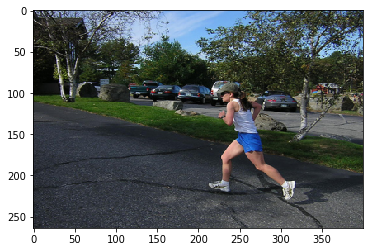

In [249]:
imr2=imread(path+"/human detection/test_image/2011_006151.jpg",as_gray=False)
#print("im2", imr2)
print(imr2.shape)
w=imr2.shape[1]
h=imr2.shape[0]
# resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method
print("CV", cv2.INTER_AREA)
imr2=cv2.resize(imr2, (400,264), interpolation = cv2.INTER_AREA) 
#print("im2",imr2)
imm=imr2
imr2.shape
print(imr2.shape)
plt.imshow(imr2)

1
2
3
4
5
6
7
8
9
10
time: 0:00:23.718003


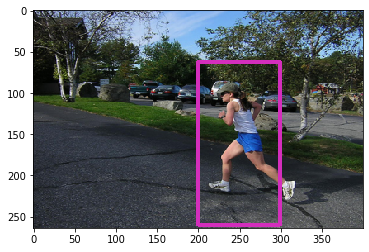

In [250]:
aa,pr=generator(imr2)
t=[]
#print(aa.shape)
#t=fix2(fix(fix3(np.array(aa).reshape((-1,4)),np.array(pr).reshape((-1,1)))),0.3)
#print("aa Value", aa)
ArrayConv = np.array(aa).reshape((-1,4))
#print("ArrayConv", ArrayConv)
#fixValue = fix2(ArrayConv,0.3)
t = fix2(ArrayConv,0.2)
#print("Fix Value", fixValue)
#t=remove_boxes(fixValue)
#print("t value",t)
#t=fix2(fix2(np.array(aa).reshape((-1,4)),0.2),0.1)
im=[]
for i in range(0,len(t)):
    d=t[i,:]
    im=imr2[d[1]:d[3],d[0]:d[2]]    
    #plt.imshow(im)
    if(d[3]!=0):
        cv2.rectangle(imm,(d[0],d[1]),(d[2],d[3]),(np.random.randint(255),np.random.randint(255),
                                                       np.random.randint(255)),3)
            
plt.imshow(imr2)